# Code for <code>bclr</code> (multiple changepoint setting)

Via examples from <i>Bayesian changepoint detection via logistic regression <br>
and the topological analysis of image series</i> by Thomas, Jauch, and Matteson (2025)

In [1]:
import bclr
import ruptures as rpt
import numpy as np
from ruptures.metrics import randindex
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import pandas as pd
import changeforest
from sklearn.linear_model import LogisticRegression, LinearRegression
from ecp import e_divisive

from scipy.special import comb
from scipy.stats import median_abs_deviation as mad
from sklearn.metrics import adjusted_rand_score

pf = PolynomialFeatures(include_bias=False)
ss = StandardScaler()

## A simple multiple changepoint demo

In [2]:
def kcp_slhr(signal, Dmax = 99, div_med = False, 
             gamma=1, alpha=2, plot = False, median = False):
    "Implements slope heuristic of Arlot, Celisse, and Harchaoui (2019)"
    mads = mad(np.abs(np.diff(signal, axis=0)), axis=0)
    if div_med:
        signal = signal/mads

    if median:
        # calculate bandwidth via median heuristic
        cost_obj = rpt.costs.CostRbf(gamma=None)
        cost_obj.fit(signal)
        gamma = cost_obj.gamma
    else: 
        cost_obj = rpt.costs.CostRbf(gamma=gamma)
        cost_obj.fit(signal)
        
    kcp_obj = rpt.KernelCPD(kernel='rbf', params={'gamma': gamma})
    kcp_obj.fit(signal)
    
    Dlow = int(0.6*Dmax)
    y = []
    n = len(signal)
    for k in range(1, Dmax+1):
        bkps_k = kcp_obj.predict(n_bkps=k)
        y.append(cost_obj.sum_of_costs(bkps_k))
    
    x1 = np.log(comb(np.repeat(n-1, Dmax), np.arange(1, Dmax+1)-1))/n
    x2 = np.arange(1, Dmax+1)/n
    X = np.c_[x1, x2]
    
    lrs = LinearRegression()
    lrs.fit(X[(Dlow-1):,:], y[(Dlow-1):])
    pen = (X @ np.expand_dims(-alpha*lrs.coef_, axis=1))[:,0]
    ncps = np.argmin(y + pen)

    if plot:
        plt.plot(np.arange(1, Dmax+1), y, color='black')
        plt.plot(np.arange(1, Dmax+1), y+pen, color='red', linestyle='dashed')
        plt.legend(labels=['Cost', 'Penalized Cost'])
        
    return kcp_obj.predict(n_bkps=ncps+1)


Multiple changepoint demo

In [3]:
np.random.seed(191293)
n, dim = 1000, 5 # number of samples, dimension
n_bkps, sigma = 10, 3 # number of change points, noise standard deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

In [4]:
prior_cov=np.diag(np.repeat(1, 5))
rng = np.random.default_rng(780090)
bclrM = bclr.MultiBayesCC(signal, cps=20, prior_cov=prior_cov, 
                          rng=rng, warnings=False)
cps_df = bclrM.fit_predict()

In [5]:
print(cps_df)

   Location  Posterior Probability  Normalized Entropy
0      82.0                  0.866            0.089605
1     158.0                  0.984            0.018249
2     243.0                  0.986            0.015938
3     331.0                  0.620            0.134812
4     434.0                  0.398            0.251708
5     534.0                  0.982            0.020618
6     619.0                  0.998            0.002778
7     715.0                  0.848            0.102534
8     798.0                  0.998            0.002761
9     902.0                  0.844            0.102895


In [6]:
cps = cps_df['Location'].to_list() + [n]
randindex(cps, bkps)

0.9992132132132132

### Look at how BCLR identifies the changes in each coordinate!!!

In [8]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM.bccs_]

[array([0.774, 0.   , 1.   , 1.   , 0.728]),
 array([0.002, 0.984, 0.998, 0.998, 0.584]),
 array([1.   , 0.154, 1.   , 0.   , 0.996]),
 array([0.992, 0.   , 0.826, 0.008, 0.   ]),
 array([0.998, 0.   , 0.958, 1.   , 1.   ]),
 array([0.982, 1.   , 0.   , 0.194, 0.056]),
 array([1.   , 0.   , 0.   , 0.898, 0.   ]),
 array([0.992, 0.994, 0.   , 0.   , 0.01 ]),
 array([0.004, 0.   , 0.   , 0.518, 0.   ]),
 array([0.158, 1.   , 0.964, 0.242, 0.   ])]

In [9]:
[bc.post_beta_mean for bc in bclrM.bccs_]

[array([ 0.32530018, -2.39067919,  1.59421588,  2.06366394,  0.25471678]),
 array([-1.76674675,  1.47402536,  1.74974946,  1.7207937 ,  0.05113933]),
 array([ 1.90700787, -0.54537918,  1.51527909, -1.70765536,  1.78929078]),
 array([ 1.22569793, -2.65917114,  0.38262327, -0.94746751, -2.08650367]),
 array([ 0.84008624, -1.73448836,  0.41807648,  2.03180277,  1.51664801]),
 array([ 0.90688615,  2.92183515, -2.15751196, -0.33678966, -0.63930898]),
 array([ 2.47737449, -1.3421838 , -1.9312593 ,  0.42698954, -1.1299377 ]),
 array([ 1.12718836,  1.3804794 , -2.59129292, -1.84564862, -0.93923268]),
 array([-1.4119866 , -1.67201144, -1.8034555 ,  0.03307942, -2.21914984]),
 array([-0.54447489,  2.22064465,  1.00579388, -0.3099198 , -2.68422862])]

### Other methods...

In [10]:
cps_cf = changeforest.changeforest(signal).split_points() + [n]
randindex(cps_cf, bkps)

0.9956376376376377

0.9996176176176176

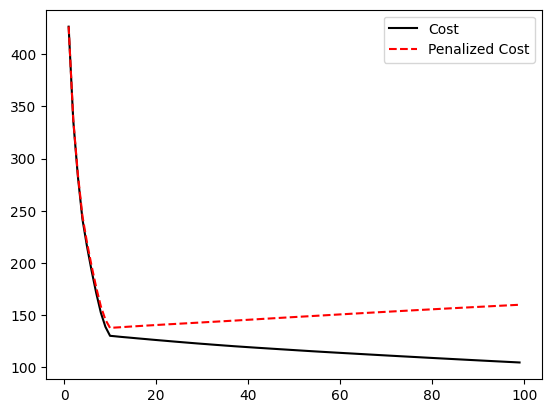

In [11]:
cps_kcp = kcp_slhr(signal, plot=True, median=True)
randindex(cps_kcp, bkps)

## What if we looked at changes of differing nature?

### Complicated change of variance, mean, and covariance 

In [12]:
np.random.seed(881977)
h1 = np.array([[1, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
h2 = np.array([[4, 0.4, 0.2], [0.4, 1, 0], [0.2, 0, 1]])
h3 = np.array([[4, 0.4, -1.7], [0.4, 1, 0], [-1.7, 0, 1]])
L1 = np.linalg.cholesky(h1)
L2 = np.linalg.cholesky(h2)
L3 = np.linalg.cholesky(h3)

a = (L1 @ np.random.randn(100, 3).T).T
b = (L2 @ np.random.randn(75, 3).T).T
c = (L2 @ np.random.randn(30, 3).T).T + np.broadcast_to([0, 3, 0], (30, 3))
d = (L3 @ np.random.randn(45, 3).T).T + np.broadcast_to([0, 3, 0], (45, 3))

X = np.r_[a,b,c,d]
Xnew = ss.fit_transform(pf.fit_transform(np.r_[a,b,c,d]))
prior_cov9 = np.diag(np.repeat(1, 9))

In [13]:
bclrM_new = bclr.MultiBayesCC(Xnew, cps=10, prior_cov=prior_cov9, rng=rng, warnings=False)
cps=bclrM_new.fit_predict()

In [14]:
print(cps)

   Location  Posterior Probability  Normalized Entropy
0     175.0                  0.826            0.116438
1     203.0                  0.508            0.310307


In [15]:
def seg_to_lab(cps):
    K = len(cps)
    vals = [np.repeat(0, cps[0])] + [np.repeat(i, cps[i]-cps[i-1]) for i in range(1, K)]
    return np.concatenate(vals, axis=0)

def adj_rand(bkps, bkps_true):
    bkp_lab = seg_to_lab(bkps)
    bkp_labt = seg_to_lab(bkps_true)
    return adjusted_rand_score(bkp_lab, bkp_labt)

In [16]:
changes = [100, 175, 205, 250]

In [17]:
cps_bclr = cps['Location'].to_list()+[250]
adj_rand(cps_bclr, changes)

0.5228589636363582

In [18]:
randindex(cps_bclr, changes)

0.7543453815261044

In [19]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM_new.bccs_]

[array([0.32 , 1.   , 0.894, 0.936, 0.22 , 0.12 , 1.   , 0.976, 0.172]),
 array([0.44 , 0.776, 0.178, 0.05 , 0.332, 0.   , 0.298, 0.498, 0.   ])]

### Performance of other methods on this task...

In [20]:
cf_res = changeforest.changeforest(Xnew).split_points()+[250]
print(cf_res)
print(randindex(cf_res, changes))

adj_rand(cf_res, changes)

[175, 250]
0.7156626506024096


0.46580124359114217

In [21]:
cf_ecp = e_divisive.e_divisive(Xnew)['estimates'][1:]
adj_rand(cf_ecp, changes)

0.46580124359114217

In [22]:
kcp_obj = rpt.KernelCPD(kernel='rbf')
kcp_obj.fit(X)

0.46580124359114217

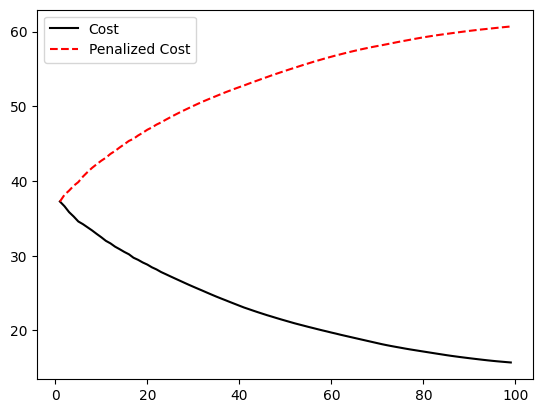

In [23]:
cf_kcp = kcp_slhr(X, plot=True, gamma=0.02)
adj_rand(cf_kcp, changes)

### Central England temperature series

In [37]:
import re
f = open("mean_temps_central_england.txt", "r")
lines = [re.sub(r"\n", "", re.sub(r"[ ]+", " ", a)).split(" ") for a in f.readlines()]

In [38]:
mtu = pd.DataFrame([l[1:] for l in lines[5:]], columns=lines[4][1:])
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)
rng = np.random.default_rng(199210)
prior_cov1 = np.diag(np.repeat(1,1))

In [39]:
bclrM_os = bclr.MultiBayesCC(Xcet, cps=10, prior_cov=prior_cov1, n_iter=5000, 
                             rng=rng, warnings=False)
df_os = bclrM_os.fit_predict(offset=1658)

In [40]:
df_os

,Location,Posterior Probability,Normalized Entropy
0,1892.0,0.0916,0.591245


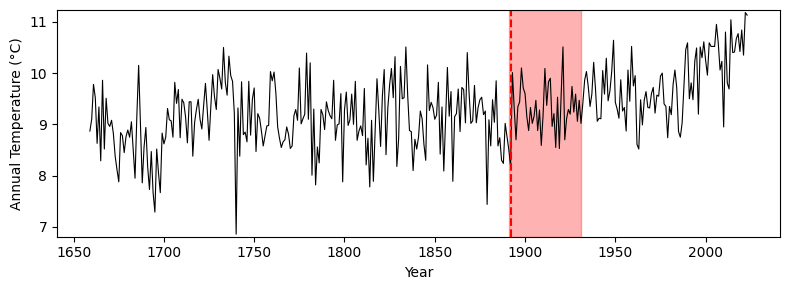

In [41]:
#plt.rcParams['font.family'] = 'Nunito'
plt.figure(figsize=(8, 3))
Xcet_ = mtu[['Annual']][:-1].to_numpy(dtype=np.double)[:,0]
years = mtu[['Year']][:-1].to_numpy(dtype=np.double)[:,0]
plt.plot(years, Xcet_, color='black', linewidth=0.8)

for i in df_os.index:
    plt.axvline(df_os['Location'][i], color='red', linestyle='--')
    plt.ylim(min(Xcet_)-0.05, max(Xcet_)+0.05)
    x1, x2 = np.quantile(bclrM_os.bccs_[i].post_k, (0.025, 0.975))+1658
    plt.fill_betweenx(np.linspace(min(Xcet_)-0.05, max(Xcet_)+0.05, 100), x1, x2, color='red', alpha=0.3)
    plt.ylabel("Annual Temperature (°C)")
    plt.xlabel("Year")

plt.tight_layout()
#plt.savefig("cet_oob.pdf")

In [42]:
cps = list(np.array([1700, 1739, 1988])-1658)

rng2 = np.random.default_rng(395922)
bclrM_cet2 = bclr.MultiBayesCC(Xcet, cps=cps, prior_cov=prior_cov1, 
                              n_iter=5000, rng=rng, lam=1)

bclrM_cet2.fit()
bclrM_cet2.transform()
df_dis2 = bclrM_cet2.cps_df(offset=1658)

In [43]:
df_dis2

,Location,Posterior Probability,Normalized Entropy
0,1701.0,0.2772,0.460855
1,1739.0,0.1088,0.539682
2,1987.0,0.1684,0.490858


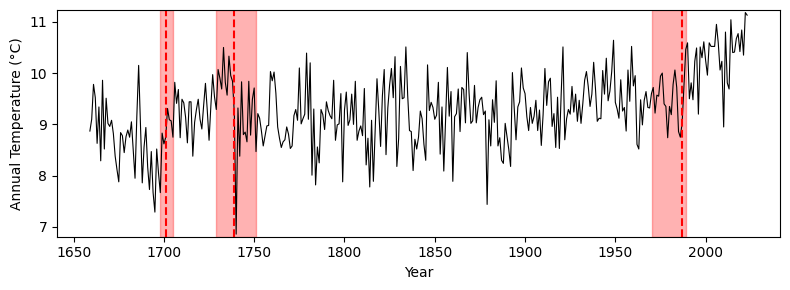

In [44]:
plt.figure(figsize=(8, 3))
plt.plot(years, Xcet_, color='black', linewidth=0.8)

for i in range(len(df_dis2)):
    plt.axvline(df_dis2['Location'].iloc[i], color='red', linestyle='--')
    x1, x2 = np.quantile(bclrM_cet2.bccs_[i].post_k, (0.025, 0.975))+1658
    plt.fill_betweenx(np.linspace(min(Xcet_)-0.05, max(Xcet_)+0.05, 100), x1, x2, color='red', alpha=0.3)
    plt.ylim(min(Xcet_)-0.05, max(Xcet_)+0.05)
    plt.ylabel("Annual Temperature (°C)")
    plt.xlabel("Year")

plt.tight_layout()
#plt.savefig("cet_prior.pdf")

In [45]:
np.array(kcp_slhr(Xcet)[:-1])+1658

array([1701, 1988])

In [46]:
op = changeforest.changeforest(Xcet)
np.array(op.split_points())+1658

array([1982, 1988])